In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import shap
import tensorflow.keras.backend 
from matplotlib import pyplot
import matplotlib.pyplot as plt
shap.initjs()

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood a

In [2]:
import deeplift

# supress deprecation warnings from TF
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
sess = tf.InteractiveSession()

In [4]:
from tensorflow.keras.models import model_from_json

keras_model_weights = "final_model/keras2_conv1d.h5"
keras_model_json = "final_model/keras2_conv1d.json"

keras_model = model_from_json(open(keras_model_json).read())
keras_model = tensorflow.keras.models.load_model(keras_model_weights)
keras_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 25, 64)            128       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 25, 128)           8320      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 25, 256)           33024     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 25, 256)           65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 256)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [5]:
train_set=read_csv('data/train_set.csv')
val_set=read_csv('data/val_set.csv')
test_set=read_csv('data/test_set.csv')

In [6]:
trainy=read_csv('data/trainy.csv')
valy=read_csv('data/valy.csv')
testy=read_csv('data/testy.csv')

In [7]:
df = read_csv('data/orginal_data.csv')

In [8]:
# make the range between 0 and 1
column = list(train_set.columns.values)
for col in column:
    minimum = df[col].min()
    maximum = df[col].max()
    train_set[col] = (train_set[col] - minimum)/(maximum-minimum)
    val_set[col] = (val_set[col] - minimum)/(maximum-minimum)
    test_set[col] = (test_set[col] - minimum)/(maximum-minimum)

In [9]:
train_set = train_set.values
val_set = val_set.values
test_set = test_set.values

In [10]:
train_set = np.reshape(train_set, (train_set.shape[0],train_set.shape[1],1))
val_set = np.reshape(val_set, (val_set.shape[0],val_set.shape[1],1))
test_set = np.reshape(test_set, (test_set.shape[0],test_set.shape[1],1))

In [11]:
from deeplift.layers import NonlinearMxtsMode
import deeplift.conversion.kerasapi_conversion as kc
from collections import OrderedDict

method_to_model = OrderedDict()
for method_name, nonlinear_mxts_mode in [
    #The genomics default = rescale on conv layers, revealcance on fully-connected
    ('rescale_conv_revealcancel_fc', NonlinearMxtsMode.DeepLIFT_GenomicsDefault),
    ('rescale_all_layers', NonlinearMxtsMode.Rescale),
    ('revealcancel_all_layers', NonlinearMxtsMode.RevealCancel),
    ('grad_times_inp', NonlinearMxtsMode.Gradient),
    ('guided_backprop', NonlinearMxtsMode.GuidedBackprop)]:
    method_to_model[method_name] = kc.convert_model_from_saved_files(
        h5_file=keras_model_weights,
        json_file=keras_model_json,
        nonlinear_mxts_mode=nonlinear_mxts_mode)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault


The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


For layer 0 the preceding linear layer is preact_0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 1 the preceding linear layer is preact_1 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 2 the preceding linear layer is preact_2 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 3 the preceding linear layer is preact_3 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 6 the preceding linear layer is preact_6 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an intermediate layer

In [12]:
######### sanity checks ########
from deeplift.util import compile_func
model_to_test = method_to_model['revealcancel_all_layers']
deeplift_prediction_func = compile_func([model_to_test.get_layers()[0].get_activation_vars()],
                                         model_to_test.get_layers()[-1].get_activation_vars())
original_model_predictions = keras_model.predict(test_set, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[test_set],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
print("maximum difference in predictions:",np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)))
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)) < 10**-5
predictions = converted_model_predictions

Using TensorFlow backend.


maximum difference in predictions: 0.0


In [13]:
revealcancel_model = method_to_model['revealcancel_all_layers']
grad_model = method_to_model['grad_times_inp']
guided_backprop_model = method_to_model['guided_backprop']
rescale_conv = method_to_model['rescale_conv_revealcancel_fc']
rescale_all = method_to_model['rescale_all_layers']

In [14]:
rescale_all.get_layers()

In [15]:
######## compute importance scores ##########
from keras import backend as K
import deeplift
from deeplift.util import get_integrated_gradients_function

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
revealcancel_fc = rescale_conv.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
revealcancel_all = rescale_all.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
#rescale_multiplier = rescale_all.get_target_multipliers_func(find_scores_layer_idx=0, target_layer_idx=-1)

grad_times_inp_func = grad_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
guided_backprop_times_inp_func = guided_backprop_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)


#To get a function that just gives the gradients, we use the multipliers of the Gradient model
gradient_func = grad_model.get_target_multipliers_func(find_scores_layer_idx=0, target_layer_idx=-2)

#pure-gradients or pure-guidedbackprop perform rather poorly because they produce scores on pixels that are 0 (which are
#the backround in MNIST). But we can give them a slight advantage by masking out positions that
#are zero. Also, the method of simonyan et al uses the magnitude of the gradient.


#prepare the integrated gradients scoring functions
#heads-up: these take 5x and 10x longer to compute respectively!
integrated_grads_5 = get_integrated_gradients_function(gradient_func, 5)
integrated_grads_10 = get_integrated_gradients_function(gradient_func, 10)

In [16]:
gradient_multiplier = np.array(gradient_func(task_idx=0,
                                         input_data_list=[test_set],
                                         batch_size=10,
                                         progress_update=10000))

No reference provided - using zeros
Done 0
Done 10000


In [17]:
gradient_multiplier.shape

(19584, 25, 1)

In [18]:
from collections import OrderedDict
method_to_task_to_scores = OrderedDict()
print("HEADS UP! integrated_grads_5 and integrated_grads_10 take 5x and 10x longer to run respectively")
print("Consider leaving them out to get faster results")
for method_name, score_func in [
                               ('rescale_conv_revealcancel_fc', revealcancel_fc),
                               ('revealcancel', revealcancel_func),
                               ('rescale_all_layers',revealcancel_all),
                               ('guided_backprop_times_inp', guided_backprop_times_inp_func),
                               
                               ('grad_times_inp', grad_times_inp_func),
                               ('integrated_grads_5', integrated_grads_5),
                               ('integrated_grads_10', integrated_grads_10)
]:
    print("Computing scores for:",method_name)
    method_to_task_to_scores[method_name] = {}
    for task_idx in range(1):
        print("\tComputing scores for task: "+str(task_idx))
        scores = np.array(score_func(
                    task_idx=task_idx,
                    input_data_list=[test_set],
                    input_references_list=[np.zeros_like(test_set)],
                    batch_size=1000,
                    progress_update=None))
        method_to_task_to_scores[method_name][task_idx] = scores

HEADS UP! integrated_grads_5 and integrated_grads_10 take 5x and 10x longer to run respectively
Consider leaving them out to get faster results
Computing scores for: rescale_conv_revealcancel_fc
	Computing scores for task: 0
Computing scores for: revealcancel
	Computing scores for task: 0
Computing scores for: rescale_all_layers
	Computing scores for task: 0
Computing scores for: guided_backprop_times_inp
	Computing scores for task: 0
Computing scores for: grad_times_inp
	Computing scores for task: 0
Computing scores for: integrated_grads_5
	Computing scores for task: 0
Computing scores for: integrated_grads_10
	Computing scores for task: 0


In [19]:
scores = method_to_task_to_scores['revealcancel']
scores1 = method_to_task_to_scores['rescale_conv_revealcancel_fc']
scores2 = method_to_task_to_scores['rescale_all_layers']
scores3 = method_to_task_to_scores['guided_backprop_times_inp']
scores4 = method_to_task_to_scores['grad_times_inp']
scores5 = method_to_task_to_scores['integrated_grads_5']
scores6 = method_to_task_to_scores['integrated_grads_10']

In [20]:
importance_score = np.reshape(scores[0], (scores[0].shape[0], scores[0].shape[1]))
importance_score1 = np.reshape(scores1[0], (scores1[0].shape[0], scores1[0].shape[1]))
importance_score2 = np.reshape(scores2[0], (scores2[0].shape[0], scores2[0].shape[1]))
importance_score3 = np.reshape(scores3[0], (scores3[0].shape[0], scores3[0].shape[1]))
importance_score4 = np.reshape(scores4[0], (scores4[0].shape[0], scores4[0].shape[1]))
importance_score5 = np.reshape(scores5[0], (scores5[0].shape[0], scores5[0].shape[1]))
importance_score6 = np.reshape(scores6[0], (scores6[0].shape[0], scores6[0].shape[1]))

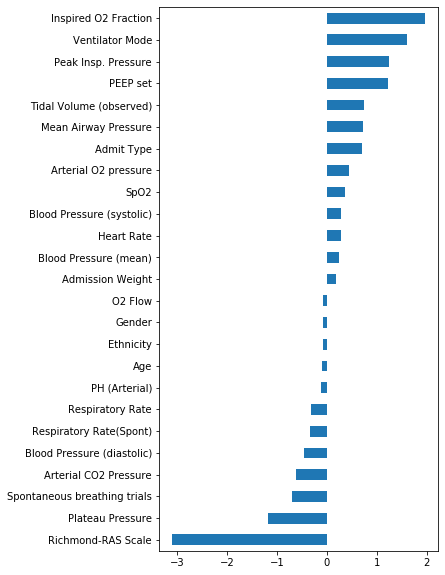

In [21]:
ave_revealcancel = np.mean(importance_score2, axis = 0)
ave_revealcancel = np.round(ave_revealcancel, 3)
ave_revealcancel = pd.Series(ave_revealcancel, index=['Admit Type', 'Ethnicity', 'Gender', 'Age', 'Admission Weight',
       'Heart Rate', 'Respiratory Rate', 'SpO2',
       'Inspired O2 Fraction', 'PEEP set', 'Mean Airway Pressure',
       'Tidal Volume (observed)', 'PH (Arterial)',
       'Respiratory Rate(Spont)', 'Richmond-RAS Scale',
       'Peak Insp. Pressure', 'O2 Flow', 'Plateau Pressure',
       'Arterial O2 pressure', 'Arterial CO2 Pressure',
       'Blood Pressure (systolic)', 'Blood Pressure (diastolic)',
       'Blood Pressure (mean)', 'Spontaneous breathing trials', 'Ventilator Mode'])
ave_revealcancel = ave_revealcancel.sort_values(ascending=True)
ave_revealcancel.plot(kind='barh', figsize=(5,10))
#plt.savefig('feature_importance')
plt.show()

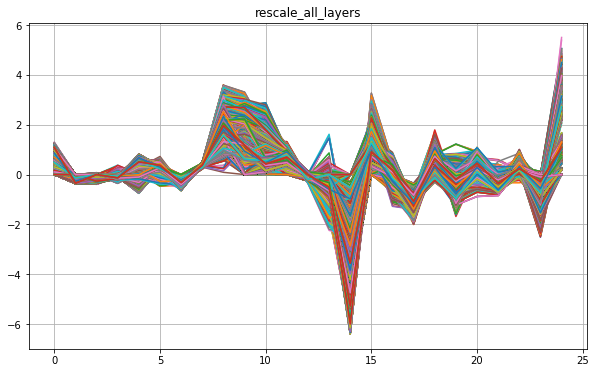

In [20]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for i in range(len(importance_score2)):
    idx_importance = importance_score2[i]
    plt.plot(idx_importance)
    plt.grid(True)
    plt.title('rescale_all_layers')

In [22]:
importance_score2[124]

array([ 0.555477  , -0.        , -0.12399741, -0.08712155,  0.65607524,
        0.19493589, -0.26156178,  0.30150905,  0.9874981 ,  1.4664364 ,
        1.0772973 ,  0.73139524, -0.20668273, -0.        , -2.0716505 ,
        1.1696159 , -0.2752966 , -1.0004053 ,  0.04960745, -0.94403994,
        0.1562203 , -0.66200495,  0.24426539, -0.63540006,  3.132909  ],
      dtype=float32)

In [23]:
importance_score2.shape

(19584, 25)

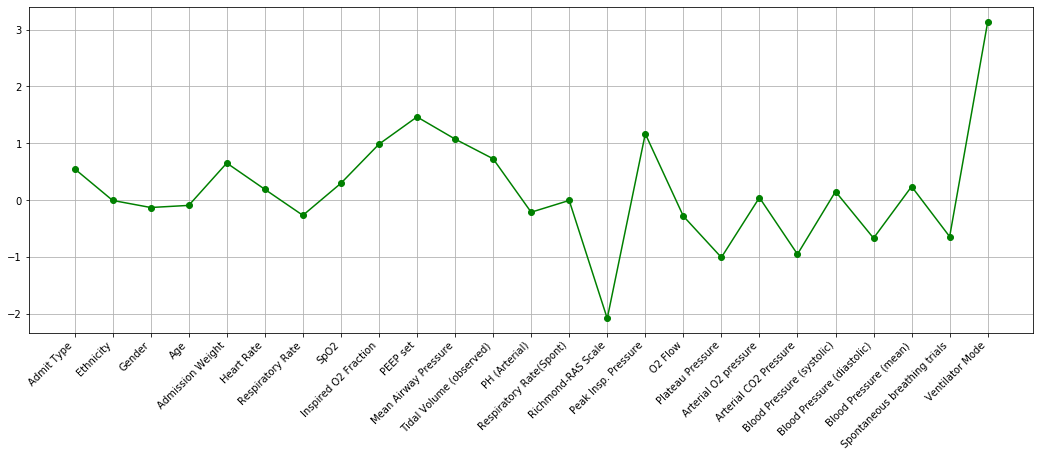

In [24]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 6))
plt.plot(importance_score2[124], 'go-')
#plt.plot([0, 25],[0,0], '--',linewidth=1)
plt.grid(True)
plt.xticks(np.arange(25),
          ['Admit Type', 'Ethnicity', 'Gender', 'Age', 'Admission Weight',
       'Heart Rate', 'Respiratory Rate', 'SpO2',
       'Inspired O2 Fraction', 'PEEP set', 'Mean Airway Pressure',
       'Tidal Volume (observed)', 'PH (Arterial)',
       'Respiratory Rate(Spont)', 'Richmond-RAS Scale',
       'Peak Insp. Pressure', 'O2 Flow', 'Plateau Pressure',
       'Arterial O2 pressure', 'Arterial CO2 Pressure',
       'Blood Pressure (systolic)', 'Blood Pressure (diastolic)',
       'Blood Pressure (mean)', 'Spontaneous breathing trials', 'Ventilator Mode'], rotation=45,horizontalalignment='right', multialignment='center')
plt.show()

In [25]:
testy.iloc[124]

Vented_1    1.0
Name: 124, dtype: float64

In [26]:
test_set.shape

(19584, 25, 1)

In [27]:
y_pred_test = keras_model.predict(test_set)

In [28]:
y_pred_test[124]

array([0.925094], dtype=float32)

In [29]:
test_set_ori=read_csv('data/test_set.csv')

In [30]:
test_set_ori.iloc[124]

Admittype                              1.00
Ethnicity                              0.00
Gender                                 1.00
Age                                   78.20
Admission Weight (Kg)                 86.50
Heart Rate                           119.00
Respiratory Rate                      24.00
O2 saturation pulseoxymetry           98.00
Inspired O2 Fraction                 100.00
PEEP set                              10.00
Mean Airway Pressure                  14.00
Tidal Volume (observed)              541.00
PH (Arterial)                          7.46
Respiratory Rate_spontaneous           0.00
Richmond-RAS Scale                    -1.00
Peak Insp. Pressure                   21.00
O2 Flow                                5.00
Plateau Pressure                      19.00
Arterial O2 pressure                 124.00
Arterial CO2 Pressure                 33.00
Arterial Blood Pressure systolic     101.00
Arterial Blood Pressure diastolic     65.00
Arterial Blood Pressure mean    

In [31]:
background = np.zeros((1,25,1))

In [32]:
keras_model.predict(background)

array([[0.12549205]], dtype=float32)

In [33]:
#shap explanation##########

In [34]:
# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(keras_model,  background)
shap_values = explainer.shap_values(test_set)

keras is no longer supported, please use tf.keras instead.


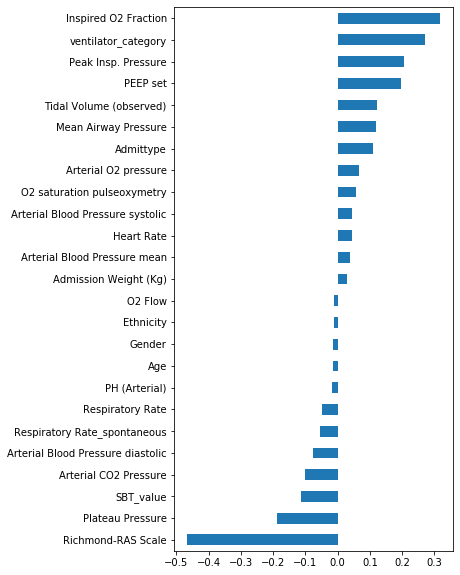

In [35]:
importance_shap = np.reshape(shap_values[0], (shap_values[0].shape[0], shap_values[0].shape[1]))
ave_shap= np.mean(importance_shap, axis = 0)
ave_shap = np.round(ave_shap, 4)
ave_shap = pd.Series(ave_shap, index=column)
ave_shap = ave_shap.sort_values(ascending=True)
ave_shap.plot(kind='barh', figsize=(5,10))
plt.show()

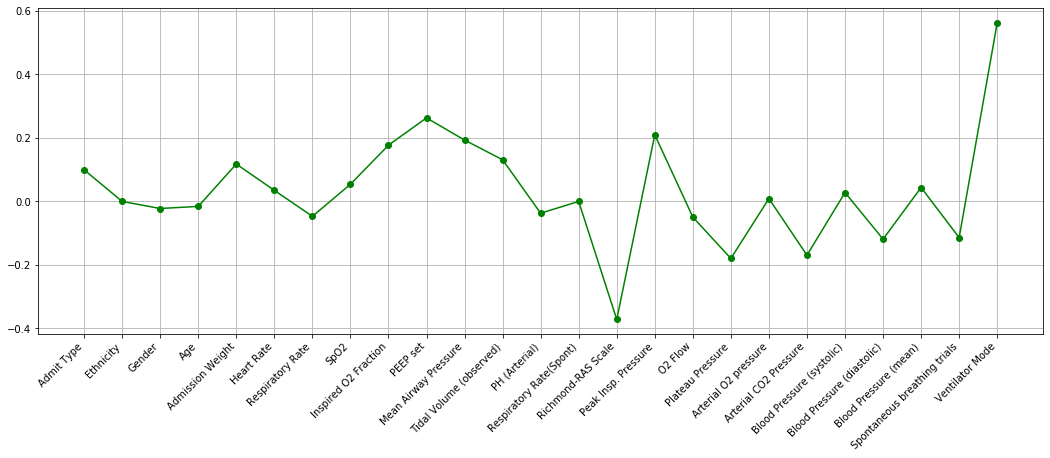

In [36]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 6))
plt.plot(importance_shap[124], 'go-')
#plt.plot([0, 25],[0,0], '--',linewidth=1)
plt.grid(True)
plt.xticks(np.arange(25),
          ['Admit Type', 'Ethnicity', 'Gender', 'Age', 'Admission Weight',
       'Heart Rate', 'Respiratory Rate', 'SpO2',
       'Inspired O2 Fraction', 'PEEP set', 'Mean Airway Pressure',
       'Tidal Volume (observed)', 'PH (Arterial)',
       'Respiratory Rate(Spont)', 'Richmond-RAS Scale',
       'Peak Insp. Pressure', 'O2 Flow', 'Plateau Pressure',
       'Arterial O2 pressure', 'Arterial CO2 Pressure',
       'Blood Pressure (systolic)', 'Blood Pressure (diastolic)',
       'Blood Pressure (mean)', 'Spontaneous breathing trials', 'Ventilator Mode'], rotation=45,horizontalalignment='right', multialignment='center')
plt.show()

In [37]:
import dice_ml3d
#from dice_ml3d.utils import helpers # helper functions

In [38]:
df = read_csv('data/orginal_data.csv')

In [39]:
df.columns

Index(['timestamp', 'hadm', 'Admittype', 'Admdays', 'Ethnicity', 'Gender',
       'Age', 'Admission Weight (Kg)', 'Heart Rate', 'Respiratory Rate',
       'O2 saturation pulseoxymetry', 'Inspired O2 Fraction', 'PEEP set',
       'Mean Airway Pressure', 'Ventilator Mode', 'Tidal Volume (observed)',
       'PH (Arterial)', 'Respiratory Rate_spontaneous', 'Richmond-RAS Scale',
       'Peak Insp. Pressure', 'O2 Flow', 'Plateau Pressure',
       'Arterial O2 pressure', 'Arterial CO2 Pressure', 'Vented',
       'Arterial Blood Pressure systolic', 'Arterial Blood Pressure diastolic',
       'Arterial Blood Pressure mean', 'SBT_value', 'Vented_1',
       'ventilator_category'],
      dtype='object')

In [40]:
df = df.drop(['timestamp', 'hadm', 'Admdays', 'Ventilator Mode', 'Vented'], axis=1)

In [41]:
d = dice_ml3d.Data(dataframe=df, continuous_features= ['Admittype', 'Ethnicity', 'Gender', 'Age', 'Admission Weight (Kg)',
       'Heart Rate', 'Respiratory Rate', 'O2 saturation pulseoxymetry',
       'Inspired O2 Fraction', 'PEEP set', 'Mean Airway Pressure',
       'Tidal Volume (observed)', 'PH (Arterial)',
       'Respiratory Rate_spontaneous', 'Richmond-RAS Scale',
       'Peak Insp. Pressure', 'O2 Flow', 'Plateau Pressure',
       'Arterial O2 pressure', 'Arterial CO2 Pressure',
       'Arterial Blood Pressure systolic', 'Arterial Blood Pressure diastolic',
       'Arterial Blood Pressure mean', 'SBT_value', 'ventilator_category'], outcome_name='Vented_1')

In [42]:
tf.get_default_session()

In [43]:
backend = 'TF'+tf.__version__[0] # TF1
m = dice_ml3d.Model(model=keras_model, backend=backend)

In [44]:
exp = dice_ml3d.Dice(d,m)

In [45]:
#### query_instance must be in list format and not normalized ####
query_instance = test_set_ori.iloc[124]
query_instance = query_instance.values
query_instance = list(query_instance)

In [46]:
query_instance

[1.0,
 0.0,
 1.0,
 78.2,
 86.5,
 119.0,
 24.0,
 98.0,
 100.0,
 10.0,
 14.0,
 541.0,
 7.46,
 0.0,
 -1.0,
 21.0,
 5.0,
 19.0,
 124.0,
 33.0,
 101.0,
 65.0,
 76.0,
 0.0,
 18.0]

In [53]:
dice_exp1 = exp.generate_counterfactuals(query_instance,total_CFs=11, desired_class="opposite", features_to_vary=['Heart Rate', 'Respiratory Rate', 'O2 saturation pulseoxymetry',
       'Inspired O2 Fraction', 'PEEP set', 'Mean Airway Pressure',
       'Tidal Volume (observed)', 'PH (Arterial)',
       'Respiratory Rate_spontaneous', 'Richmond-RAS Scale',
       'Peak Insp. Pressure', 'O2 Flow', 'Plateau Pressure',
       'Arterial O2 pressure', 'Arterial CO2 Pressure',
       'Arterial Blood Pressure systolic', 'Arterial Blood Pressure diastolic',
       'Arterial Blood Pressure mean', 'SBT_value', 'ventilator_category'] )

Diverse Counterfactuals found! total time taken: 00 min 18 sec


In [54]:
dice_exp1.visualize_as_dataframe()

Query instance (original outcome : 1)


,Admittype,Ethnicity,Gender,Age,Admission Weight (Kg),Heart Rate,Respiratory Rate,O2 saturation pulseoxymetry,Inspired O2 Fraction,PEEP set,...,O2 Flow,Plateau Pressure,Arterial O2 pressure,Arterial CO2 Pressure,Arterial Blood Pressure systolic,Arterial Blood Pressure diastolic,Arterial Blood Pressure mean,SBT_value,ventilator_category,Vented_1
0,1.0,0.0,1.0,78.2,86.5,119.0,24.0,98.0,100.0,10.0,...,5.0,19.0,124.0,33.0,101.0,65.0,76.0,0.0,18.0,0.925094



Diverse Counterfactual set (new outcome : 0)


,Admittype,Ethnicity,Gender,Age,Admission Weight (Kg),Heart Rate,Respiratory Rate,O2 saturation pulseoxymetry,Inspired O2 Fraction,PEEP set,...,O2 Flow,Plateau Pressure,Arterial O2 pressure,Arterial CO2 Pressure,Arterial Blood Pressure systolic,Arterial Blood Pressure diastolic,Arterial Blood Pressure mean,SBT_value,ventilator_category,Vented_1
0,1.0,0.0,1.0,78.2,86.5,119.1,23.9,98.0,100.0,10.2,...,5.0,19.0,152.1,33.0,93.9,65.2,84.1,1.0,3.0,0.130
1,1.0,0.0,1.0,78.2,86.5,118.9,29.0,98.0,100.0,0.0,...,9.2,19.0,124.4,33.0,91.5,40.7,75.7,1.0,10.0,0.032
2,1.0,0.0,1.0,78.2,86.5,118.9,24.1,94.0,100.0,10.3,...,5.0,19.0,124.4,28.0,101.2,64.8,92.3,1.0,13.0,0.222
3,1.0,0.0,1.0,78.2,86.5,118.9,24.9,98.0,100.0,10.0,...,5.0,19.0,60.0,33.0,111.4,60.9,75.7,0.0,2.0,0.482
4,1.0,0.0,1.0,78.2,86.5,129.5,36.0,98.0,100.0,0.0,...,6.2,21.4,123.6,33.0,100.8,87.9,67.8,1.0,9.0,0.016
5,1.0,0.0,1.0,78.2,86.5,138.2,24.1,98.0,100.0,10.0,...,5.0,19.0,123.6,33.0,101.2,59.4,75.7,1.0,10.0,0.194
6,1.0,0.0,1.0,78.2,86.5,107.7,14.0,98.0,100.0,2.7,...,5.0,19.0,124.4,33.0,100.8,65.2,75.7,0.0,21.0,0.457
7,1.0,0.0,1.0,78.2,86.5,118.9,23.9,98.0,100.0,0.0,...,5.0,19.0,123.6,33.0,105.6,67.5,42.4,1.0,4.0,0.074
8,1.0,0.0,1.0,78.2,86.5,119.1,22.8,98.0,100.0,4.9,...,22.6,19.0,124.4,33.0,96.3,70.8,80.2,0.0,0.0,0.146
9,1.0,0.0,1.0,78.2,86.5,119.1,24.1,96.0,100.0,5.1,...,6.6,19.0,123.6,33.0,100.8,65.2,71.7,0.0,18.0,0.099


In [54]:
##### test_instance which is normalized ######
instance = dice_exp1.test_instance

In [55]:
instance = np.reshape(instance, (1, 25, 1))

In [56]:
####### check the predcition of 124th patient, should be the same as y_pred_test[124] #########
result = keras_model.predict(instance)

In [57]:
result

array([[0.92509407]], dtype=float32)

In [58]:
test_scale = read_csv('data/test_set_scaled.csv')

In [59]:
####### final_cfs_df are the counterfactural examples that already de-normalized #########
counterfacturals = dice_exp1.final_cfs_df

In [58]:
query_counter_instance = [1,0,1,78.2,86.5,110,24,98,40,5,10,541,7.46,24,0,21,5,19,118,33,101,65,76,1,4]

In [59]:
dice_exp_counter = exp.generate_counterfactuals(query_counter_instance,total_CFs=1, desired_class="opposite", features_to_vary=['Heart Rate', 'Respiratory Rate', 'O2 saturation pulseoxymetry',
       'Inspired O2 Fraction', 'PEEP set', 'Mean Airway Pressure',
       'Tidal Volume (observed)', 'PH (Arterial)',
       'Respiratory Rate_spontaneous', 'Richmond-RAS Scale',
       'Peak Insp. Pressure', 'O2 Flow', 'Plateau Pressure',
       'Arterial O2 pressure', 'Arterial CO2 Pressure',
       'Arterial Blood Pressure systolic', 'Arterial Blood Pressure diastolic',
       'Arterial Blood Pressure mean', 'SBT_value', 'ventilator_category'] )

Diverse Counterfactuals found! total time taken: 00 min 07 sec


In [60]:
query_instance = dice_exp_counter.test_instance

In [61]:
query_instance = np.reshape(query_instance, (1, 25, 1))

In [62]:
###### prediction results for changing Arterial O2 pressure from 118 to 124 in the counterfactual example######
keras_model.predict(query_instance)

array([[0.16797139]], dtype=float32)